# Временные ряды

## 1. Линейная регрессия

### Условия Гаусса-Маркова

Мы можем использовать линейную регрессию для предсказания. Модель выглядит так:
$$y_i = kx_i + b + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2)$$

Здесь $\epsilon$ – белый шум, находящийся внутри $y$ и его нельзя объяснить с помощью $x$.

Есть набор правил (условий), при соблюдении которых (*всех*) мы можем гарантировать, что модель будет хорошо оценивать параметры распределения:  
* Параметр $k$ – линейный
* $x$ и $y$ – случайные переменные
* Признаки $x_i$ не коллинеарны между собой (то есть, не коррелируют между собой)
* $\epsilon$ – эндогенная переменная (endogenous). Это значит, что случайный шум не зависит от наших данных
* $\epsilon$ – гомоскедастичная переменная (homoscedastic). Это значит, что дисперсия шума не зависит от наших данных
* $\epsilon$ – переменная, не имеющая автокорреляции. Это значит, что между разными значениями шума нет корреляции

Есть небольшая проблема с этими условиями, когда мы говорим о временных рядах: мы получаем наши $x$ из одного процесса, так что это больше не случайная переменная. В случае в временными рядами мы ожидаем, что все $x_i$ детерминированы и не все равны между собой.

## 2. Тренд, сезонность

**Тренд** – системная линейная или нелинейная компенента во временном ряде, которая изменяется и не повторяется со временем. Например, линейный тренд или экспоненциальный тренд. 

**Сезонность** – системная линейная или (чаще) нелинейная компонента во временном ряде, которая изменяется и повторяется со временем. 

In [ ]:
import pandas as pd

import pandas as pd
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

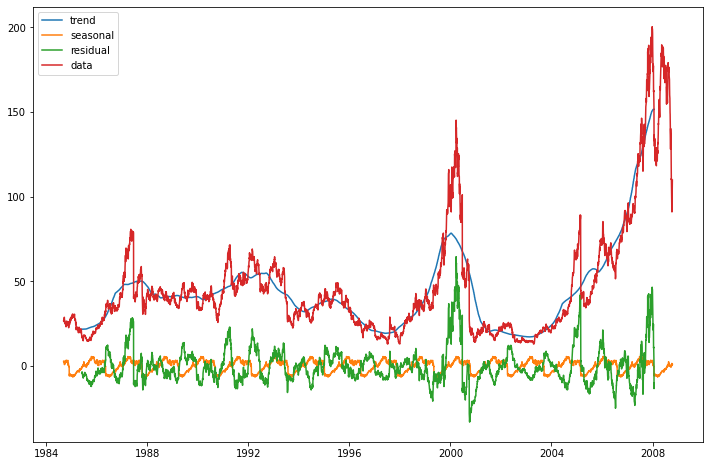

In [ ]:
df = pd.read_csv('aapl.csv', delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close'])
df.Date = pd.to_datetime(df.Date)
df['Mean'] = (df.High + df.Low ) / 2.0

decomposition = seasonal_decompose(df.Mean.values, period=365) 

plt.figure(figsize=(12, 8))
plt.plot(df.Date, decomposition.trend, label='trend')
plt.plot(df.Date, decomposition.seasonal, label='seasonal')
plt.plot(df.Date, decomposition.resid, label='residual')
plt.plot(df.Date, df['Mean'], label='data')
plt.legend();

In [ ]:
trace1 = go.Scatter(
    x = df.Date, y = decomposition.trend,
    name = 'Trend', mode='lines'
)
trace2 = go.Scatter(
    x = df.Date, y = decomposition.seasonal,
    name = 'Seasonal', mode='lines'
)
trace3 = go.Scatter(
    x = df.Date, y = decomposition.resid,
    name = 'Residual', mode='lines'
)
trace4 = go.Scatter(
    x = df.Date, y = df.Mean,
    name = 'Mean Stock Value', mode='lines'
)

data = [trace1, trace2, trace3, trace4]
plot(data);

**Бегущее среднее** – способ сглаживать данные.

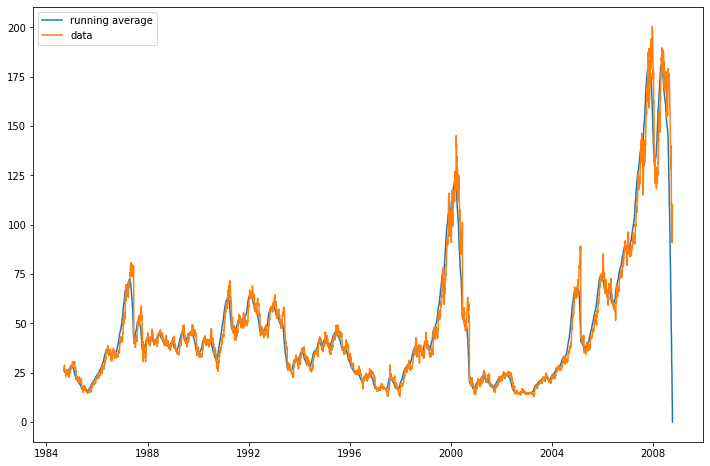

In [ ]:
running_mean = 0.0
run_avg_predictions = [running_mean]
decay = 0.95

for pred_idx in range(1, len(df.Mean)):
    running_mean = running_mean * decay + (1.0 - decay) * df.Mean[pred_idx - 1]
    run_avg_predictions.append(running_mean)

plt.figure(figsize=(12, 8))
plt.plot(df.Date, run_avg_predictions, label='running average')
plt.plot(df.Date, df['Mean'], label='data')
plt.legend();

## 3. Предсказание

Как мы делаем предсказания во временных рядах? Все логично: предсказываем следующие наблюдения по предыдущим.

### Авторегрессия

Авторегрессия – модель, которая принимает прошлые наблюдения в качестве входных данных для регрессионной модели, чтобы предсказывать следующее наблюдение.

In [ ]:
import warnings
from statsmodels.tsa.ar_model import AutoReg

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    window_size = 50
    ar_list = list(df.Mean[:window_size])
    for pred_idx in range(window_size, len(df.Mean)):

        current_window = list(df.Mean[pred_idx - window_size:pred_idx])
        model = AutoReg(current_window, [1, 4]).fit()
        current_predict = model.predict(50, 50)[0]
        ar_list.append(current_predict)

In [ ]:
ar_list_filtered = np.where(np.array(ar_list) > 1e5, 0, np.array(ar_list))

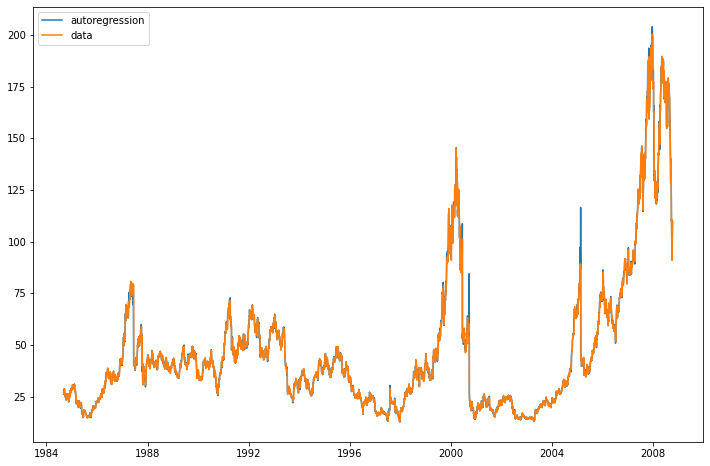

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df.Date, ar_list, label='autoregression')
plt.plot(df.Date, df['Mean'], label='data')
plt.legend();

In [ ]:
trace5 = go.Scatter(
    x = df.Date, y = ar_list,
    name = 'Auto Regression', mode='lines'
)
plot([trace4, trace5]);

### ARMA

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
simulated_ARMA_data = ArmaProcess()

Попробуем применить лог-трансформацию и возьмем разницу между соседними значениями, чтобы убрать тренд и изменение дисперсии. Такие данные будут называться стационарными.

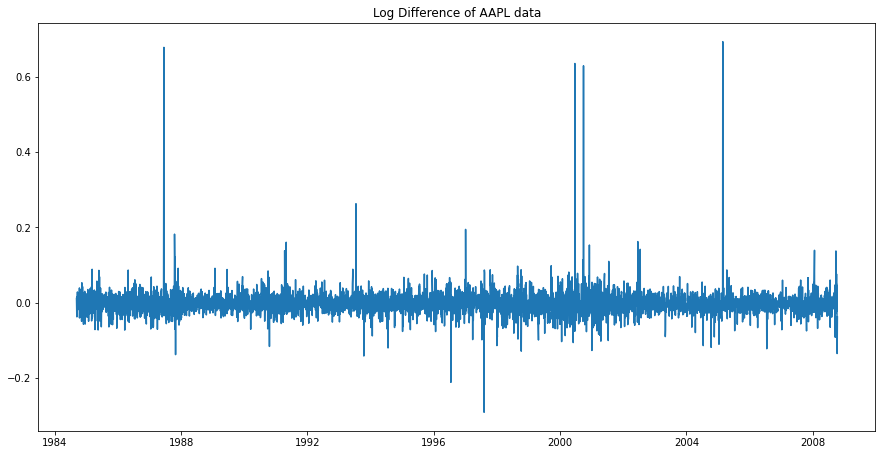

In [ ]:
stationary = np.log(df.Mean)
stationary = stationary.diff()
plt.figure(figsize=[15, 7.5])
plt.plot(df.Date, stationary)
plt.title("Log Difference of AAPL data")
plt.show()

Модель ARMA использует одновременно авторегрессию (новые значения зависят от предыдущих значений, параметр $p$) и бегущее среднее (новые значения зависят от шума на прошлых шагах, параметр $q$).  
Улучшение этой модели – ARIMA, которая также применяет разность между значениями, где параметр $d$ означает количество взятий разности для данных. Это позволяет добиться стационарности. 

Для выбора наиболее подходящих значений $p, d, q$ можно использовать Akaike’s Information Criterion или AIC (меньше – лучше).
$$AIC = -2 \log{L} + 2k$$
$L$ – likelihood данных (произведение плотностей вероятности при разных значениях параметров), $k$ – количество параметров.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from tqdm import tqdm

In [ ]:
def optimize_ARIMA(order_list, exog):
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df.Mean)
result_df

 27%|██▋       | 17/64 [00:20<01:22,  1.75s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 42%|████▏     | 27/64 [00:56<01:56,  3.15s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 44%|████▍     | 28/64 [01:02<02:24,  4.02s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 47%|████▋     | 30/64 [01:18<03:28,  6.12s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimizati

,"(p, d, q)",AIC
0,"(7, 1, 7)",24070.670749
1,"(6, 1, 7)",24076.437154
2,"(2, 1, 6)",24077.764819
3,"(7, 1, 6)",24079.094352
4,"(5, 1, 3)",24080.136240
...,...,...
59,"(0, 1, 3)",24119.416006
60,"(2, 1, 0)",24119.734402
61,"(2, 1, 1)",24120.599876
62,"(1, 1, 0)",24121.080205


In [ ]:
best_model = SARIMAX(df.Mean, order=(7, 1, 7)).fit()
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                   Mean   No. Observations:                 6081
Model:               SARIMAX(7, 1, 7)   Log Likelihood              -12020.335
Date:                Wed, 17 Nov 2021   AIC                          24070.671
Time:                        14:32:44   BIC                          24171.362
Sample:                             0   HQIC                         24105.614
                               - 6081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5199      0.053     -9.867      0.000      -0.623      -0.417
ar.L2         -0.7834      0.073    -10.776      0.000      -0.926      -0.641
ar.L3         -0.7709      0.086     -8.965      0.0

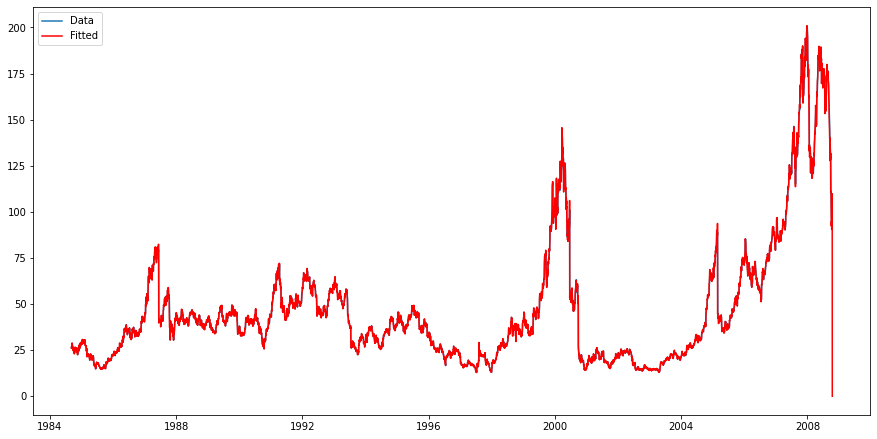

In [ ]:
plt.figure(figsize=[15, 7.5])
plt.plot(df.Date, df.Mean, label='Data')
plt.plot(df.Date, best_model.fittedvalues, color='red', label='Fitted')
plt.legend();

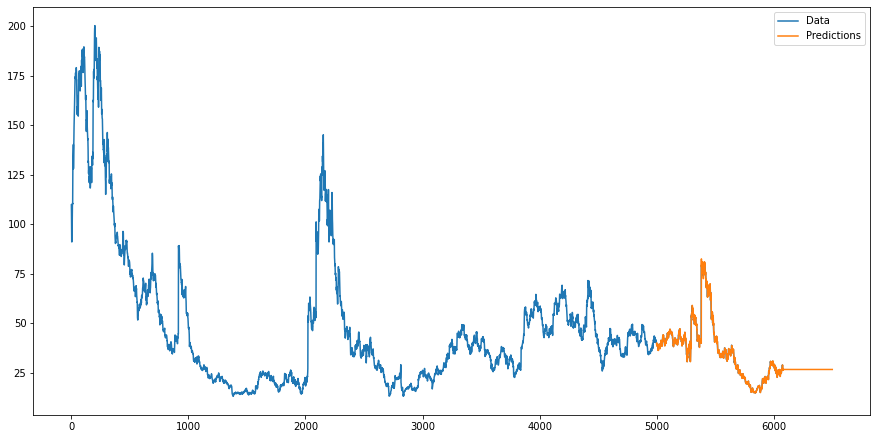

In [ ]:
plt.figure(figsize=[15, 7.5])
plt.plot(df.Mean, label='Data')
plt.plot(best_model.predict(start=5000, end=6500), label='Predictions')
plt.legend();

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(np.log(df.Mean), order=(7,1,7))
results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



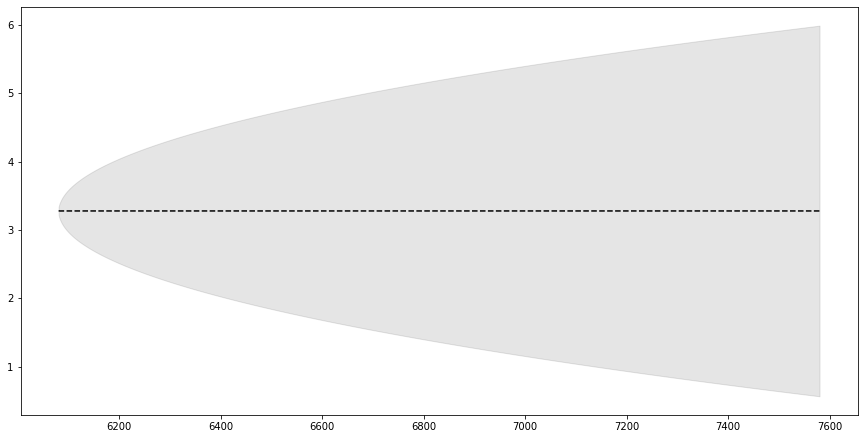

In [ ]:
_, ax = plt.subplots(figsize=(15, 7.5))

fcast = results.get_forecast(steps=1500)
fcast.predicted_mean.plot(ax=ax, style='k--')
yhat_conf_int = fcast.conf_int(alpha=0.05)
ax.fill_between(fcast.row_labels, yhat_conf_int['lower Mean'], yhat_conf_int['upper Mean'], color='k', alpha=0.1);

## 4. Интерпретация

### Автокорреляция

Автокорреляция - способ посмотреть, есть ли внутри наших данных корреляция.
Посмотрим на нее с помощью lag_plot. Возьмем довольно большое значение лага, так как у нас много точек в данных.

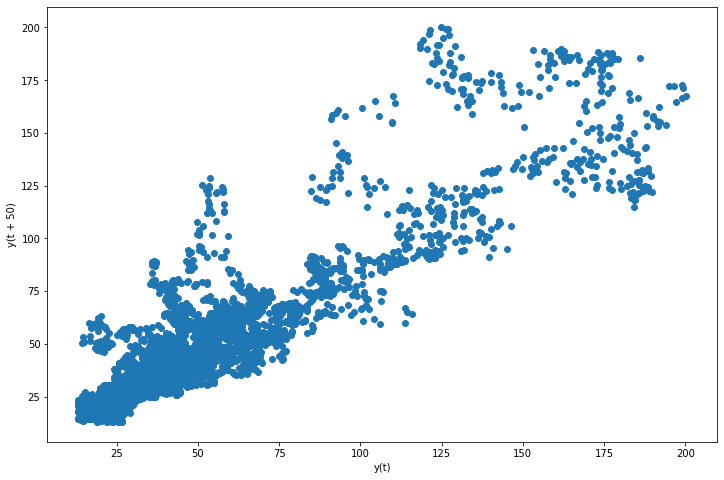

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12, 8))
lag_plot(df.Mean, lag=50);

Похоже, есть некоторая корреляция. Можем напрямую измерить коэффициент:

In [ ]:
dataframe = pd.concat([df.Mean.shift(50), df.Mean], axis=1)
dataframe.columns = ['t - 50', 't']
result = dataframe.corr()
print(result)

          t - 50         t
t - 50  1.000000  0.903867
t       0.903867  1.000000


Что, если мы попробуем убрать корреляцию взятием разности?

In [ ]:
diff_data = pd.Series(np.diff(df.Mean))
dataframe = pd.concat([diff_data.shift(50), diff_data], axis=1)
dataframe.columns = ['t - 50', 't']
result = dataframe.corr()
print(result)

         t - 50        t
t - 50  1.00000 -0.00203
t      -0.00203  1.00000


Посмотрим, как изменяется корреляция изначальных данных в зависимости от лага:

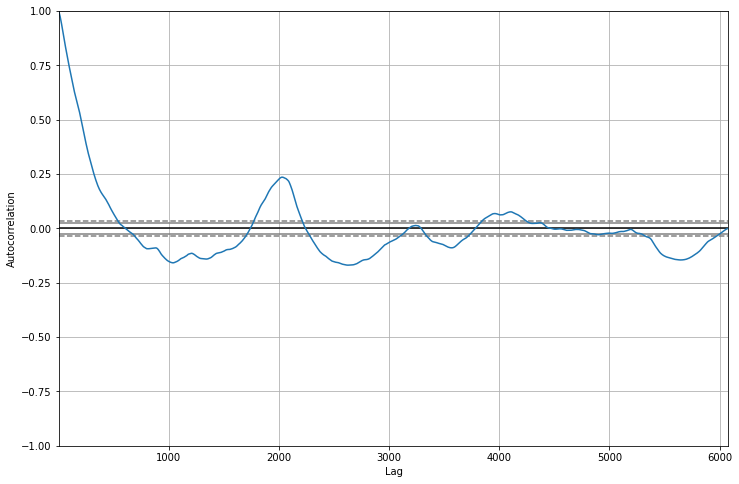

In [ ]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(12, 8))
autocorrelation_plot(df.Mean);

Мы познакомимся с генерацией нормального белого шума и посмотрим на практике, как влияет на качество OLS оценок гетероскедастичность

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

Создадим нормальный белый шум размера N с нулевым средним и единичной дисперсией. Его график совершенно хаотичен

In [ ]:
N = 40

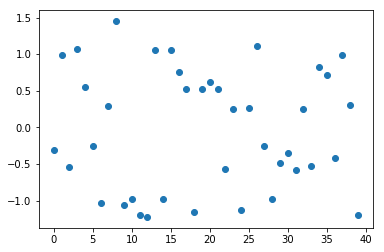

In [ ]:
mu = 0
sigma = 1 

eps = np.random.normal(mu, sigma, size=N)

plt.scatter(np.arange(N),eps)

Соединим соседние точки линиями. Это полезно, когда в качестве счетчика выступает время

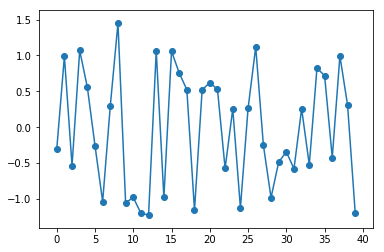

In [ ]:
plt.plot(eps)
plt.scatter(np.arange(N),eps)

Сгенерируем данные для регрессии: добавим к линейной функции y=2+x белый шум eps. Диаграмма рассеяния показывает сильный линейный паттерн и в целом ведет себя хорошо

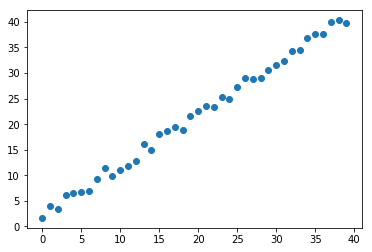

In [ ]:
x = np.arange(N)
y = 2 + x + eps
plt.scatter(x,y)

Подготовим данные для обучения классической OLS регрессии. Все условия Гаусса-Маркова выполняются: признак детерминированный (числа от 1 до N), модель хорошая, шум белый.
Мы будем пользоваться не lstsq из linalg.numpy, а  конструктором LinearRegression() из библиотеки sklearn.
Как вы помните, lstsq работает на svd разложении и требует предварительной стандартизации данных в случае существенно разных шкал признаков.
LinearRegression() делает стандартизацию сама (впрочем, это можно настроить), однако следует иметь в виду, что алгоритм внутри нее зашит другой, тоже устойчивый к "плохим" данным. Как правило, реализации алгоритмов в sklearn направлены на то, чтобы функция работала быстро.
Реализация OLS через теоретическую формулу на практике не применяется из-за плохой вычислительной устойчивости.

In [ ]:
# сначала переформатируем данные из одномерных массивов в двумерные, тк этого требует синтаксис LinearRegression() 
# при работе с реальными датасетами делать этого не нужно
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

[ 2.0087753] [[ 0.99819643]]


Одной из метрик качества модели является r2_score. Это так называемая доля объяснённой дисперсии. Она показывает, какую часть отклонений целевой переменной объясняет модель. Чем выше, тем лучше.

In [ ]:
y_pred = linreg.predict(x)
r2_score(y,y_pred)

0.99506753847984375

Теперь давайте испортим немного модель, добавив гетероскедастичность

In [ ]:
# создадим функцию, которая будет портить белый шум, добавляя в него неравные дисперсии.
# Кажое следующее значение шума будет в alpha раз выше предыдущего

def hetero_eps(alpha, eps):
    hetero_eps = np.zeros(len(eps))
    for i in range (0,len(eps)):
        hetero_eps[i] = (alpha**i) * eps[i]
    return hetero_eps

 Возьмем в качестве alpha 1.5, при этом каждое следующее отклонение будет примерно на 5% больше прыдущего.
 На графике видно, что шум "расползается". Чем больше измерений мы возьмем, тем сильнее будет расплозаться шум, а с ним и весь тренд.
 В гомоскедастичном случае (для белого шума) чем больше измерений, тем точнее будет настроена регрессия, т.к. никакого расползания там нет

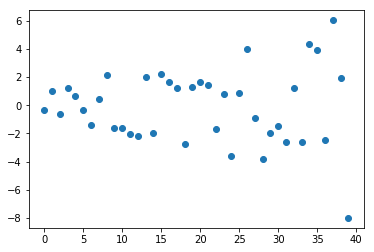

In [ ]:
alpha = 1.05
heteps = hetero_eps(alpha,eps) # гетероскедастичный шум
plt.scatter(np.arange(N),heteps)

В модель y = 2 + x добавим гетероскедастичный шум и посмотрим, что будет с регрессией

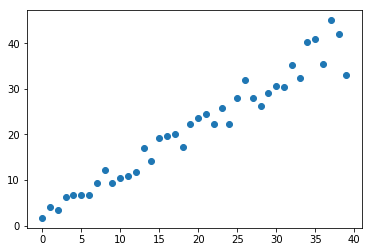

In [ ]:
x = np.arange(N)
y = 2 + x + heteps
plt.scatter(x,y) # типичная картинка увеличения дисперсии

In [ ]:
# сначала переформатируем данные из одномерных массивов в двумерные, т.к. этого требует синтаксис LinearRegression() 
# при работе с реальными датасетами делать этого не нужно
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

[ 2.01175298] [[ 0.99433009]]


Как правило, коэффициенты модели с гетероскедастичностю сильнее отличаются от настоящих значений параметров 2 и 1 по сравнению с гомоскедастичным случаем.  
Пострадает и r2_score — модель с гетероскедатсичным шумом хуже объясняет изменения y. Прогнозы в такой модели тоже будут менее точные

In [ ]:
y_pred = linreg.predict(x)
r2_score(y,y_pred)

0.95125584217547177

Пример внизу показывает, что, чем больше гетероскедастичность, тем хуже работает модель

In [ ]:
x = np.arange(N)

# увеличим амлитуду шума в 4 раза

y = 2 + x + 4*heteps
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

# найдем оценки y
y_pred = linreg.predict(x)

# выведем r2_score
print(r2_score(y,y_pred))

[ 2.04701194] [[ 0.97732034]]
0.540933056431


а вот что происходит с увеличением амплитуды шума в гомоскедатсичной модели:

In [ ]:
x = np.arange(N)
# увеличим амлитуду шума в 4 раза
y = 2 + x + 4*eps
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

# найдем оценки y
y_pred = linreg.predict(x)

# выведем r2_score
print(r2_score(y,y_pred))

[ 2.03510121] [[ 0.99278574]]
0.925773838165


Как видите, intercept модели гуляет, но коэффициент при x оценивается довольно неплохо.
r2_score тоже ожидаемо падает, но не так сильно, как в гетероскедастичном случае.

## 3. Линейная регрессия

→ Загрузите датасет BostonHousing из библиотеки sklearn

→ Обучите линейную регрессию стоимости дома на параметры CRIM, RM.

In [ ]:
import warnings
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    dataset = load_boston()
boston = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
boston = boston.drop(['ZN', 'INDUS', 'CHAS', 'NOX', 
                      'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
                      'B', 'LSTAT'], axis=1)
boston['target']=dataset.target
boston.head(2)

,CRIM,RM,target
0,0.00632,6.575,24.0
1,0.02731,6.421,21.6


In [ ]:
X, y = boston.loc[:, ['CRIM', 'RM']], boston.loc[:, ['target']]
print(X.shape, y.shape)

(506, 2) (506, 1)


In [ ]:
reg = LinearRegression().fit(X, y)

In [ ]:
print(reg.coef_, reg.intercept_)

[[-0.26491325  8.39106825]] [-29.24471945]


In [ ]:
pred = reg.predict(X)

In [ ]:
# 3.4 Найдите долю объясненной дисперсии
explained_variance_score(y_true=y, y_pred=pred)

0.5419591738494083

$explainedVariance(y, \hat y) = 1 - \frac{Var (y - \hat y)}{Var(y)}$

In [ ]:
1 - (y-pred).var()/y.var()

target    0.541959
dtype: float64

In [ ]:
r2_score(y_true=y, y_pred=pred)

0.5419591738494084

In [ ]:
# Задание 3.3
# Сгенерируйте вектор белого шума и добавьте к исходным значениям целевой переменой. 
# Обучите модель и найдите R2 (долю объясненной дисперсии).

mu = 0
sigma = 1 

eps = np.random.normal(mu, sigma, size=y.shape[0])
eps = eps.reshape((y.shape[0], y.shape[1]))
y_white = y + eps
print(y.shape)

reg_white = LinearRegression().fit(X, y_white)
pred_white = reg_white.predict(X)
r2_score(y_true=y, y_pred=pred_white)

(506, 1)


0.5418102656076758

In [ ]:
# Задание 3.4

# Сгенерируйте вектор гетероскедастичного шума аналогично разобранному примеру с параметром a=1.002 
# и добавьте к исходным значениям целевой переменной. 
# Обучите модель и найдите r2 (долю объясненной дисперсии)


In [ ]:
alpha = 1.002

def r2_hete(alpha, eps, X, y):
    hete_eps = hetero_eps(alpha, eps)
    hete_eps = eps.reshape((y.shape[0], y.shape[1]))
    y_hete_white = y + hete_eps

    reg_hete_white = LinearRegression().fit(X, y_hete_white)
    pred_hete_white = reg_hete_white.predict(X)
    r2 = r2_score(y_true=y, y_pred=pred_hete_white)

    return r2

r2_hete(alpha, eps, X, y)

0.5418102656076758

In [ ]:
# Задание 3.6

# Сгенерируйте вектор гетероскедастичного шума аналогично разобранному примеру 
# с параметром a=0.998 и добавьте к исходным значениям целевой переменной.
# Обучите модель и найдите r2 (долю объясненной дисперсии).
alpha = 0.998
r2_hete(alpha, eps, X, y)

0.5418102656076758

## 6. Скользящее среднее

данные об активности солнечных вспышек.

→ датасет solarpower_cumuldaybyday2.csv.

In [2]:
import pandas as pd

In [3]:
f = 'solarpower_cumuldaybyday2.csv'

data = pd.read_csv(f)
data = data.drop(['Unnamed: 2'], axis=1)
data.head(3)

,date,cum_power
0,26/10/2011,0.1
1,27/10/2011,10.2
2,28/10/2011,20.2


In [4]:
from datetime import date

def datify(d):
    dd, mm, year = d.split('/')
    try: 
        d = date(int(year), int(mm), int(dd))
    except ValueError as e:
        print(d)
        raise e
    return d

In [5]:
# преобразование даты в формат DateTime
# Пришлось написать функцию, так как format='%d/%m/%Y' не работал
data['date'] = data['date'].map(datify)
data['date'] = pd.to_datetime(data['date'])

data.head(10)

,date,cum_power
0,2011-10-26,0.1
1,2011-10-27,10.2
2,2011-10-28,20.2
3,2011-10-29,29.6
4,2011-10-30,34.2
5,2011-10-31,38.0
6,2011-11-01,46.6
7,2011-11-02,51.6
8,2011-11-03,58.6
9,2011-11-04,60.5


In [6]:
data['date'].min()

Timestamp('2011-10-26 00:00:00')

In [7]:
# Задание 6.1

# Постройте ряд еженедельного производства энергии, вычислив приращения полученного недельного ряда. 
# В поле для ответа введите значение произведенной энергии за неделю с 6 по 12 октября 2014, округлив до целых.

# Очистка данных от кумулятивности
cum_total = 0
net_power = []
for pow in data['cum_power']:
    day_pow = pow - cum_total 
    cum_total += day_pow
    net_power.append(day_pow)

In [8]:
# Мой тотал должен совпасть с максимальным значением в исходных данных
print(data.max())
print(cum_total)

date         2018-10-26 00:00:00
cum_power                  28120
dtype: object
28120.0


In [9]:
# преобразование очищенных данных в дата-фрейм
data_ = {'date': data['date'], 'net_pow': net_power}
net_pow_df = pd.DataFrame.from_dict(data_)
net_pow_df

,date,net_pow
0,2011-10-26,0.1
1,2011-10-27,10.1
2,2011-10-28,10.0
3,2011-10-29,9.4
4,2011-10-30,4.6
...,...,...
2553,2018-10-22,6.0
2554,2018-10-23,8.0
2555,2018-10-24,6.0
2556,2018-10-25,2.0


In [10]:
# установка индекса DateTime 
net_pow_df = net_pow_df.set_index('date')
# Группировка по неделям - способ нашел в интернете. На выходе объект pandas Series.
# Группирует с понедельнка по воскресенье
net_weekly = net_pow_df.net_pow.resample('W').sum()
net_weekly

date
2011-10-30    34.2
2011-11-06    37.6
2011-11-13    28.1
2011-11-20    36.6
2011-11-27    19.6
              ... 
2018-09-30    89.0
2018-10-07    77.0
2018-10-14    77.0
2018-10-21    55.0
2018-10-28    25.0
Freq: W-SUN, Name: net_pow, Length: 366, dtype: float64

In [11]:
# Ответ на задание 6.1
print(net_weekly.loc['2014-10-12'])

44.0


In [12]:
type(net_weekly)

pandas.core.series.Series

In [13]:
# Найдите значение ряда скользящего среднего с шириной окна 4 для t=120.
idx1 = [119, 118, 117, 116]  # правильный ответ
idx2 = [120, 119, 118, 117]
idx3 = [121, 120, 119, 118]
for idx in idx1, idx2, idx3:
    print(net_weekly.iloc[idx].sum()/4)

21.5
23.25
29.0


In [14]:
# какой номер строки у недели из первого задания?
net_weekly_df = pd.DataFrame(net_weekly)
net_weekly_df.insert(0, 'row_num', range(0, net_weekly.shape[0]))

In [15]:
net_weekly_df.loc['2014-10-12']

row_num    154.0
net_pow     44.0
Name: 2014-10-12 00:00:00, dtype: float64

In [16]:
net_weekly_df.iloc[154]

row_num    154.0
net_pow     44.0
Name: 2014-10-12 00:00:00, dtype: float64

In [17]:
# решение с помощью функций pandas, подсказанное ассистентом курса
net_weekly_df.head()

,row_num,net_pow
date,,
2011-10-30,0,34.2
2011-11-06,1,37.6
2011-11-13,2,28.1
2011-11-20,3,36.6
2011-11-27,4,19.6


In [18]:
# кол-во элементов
net_weekly_df['delta_roll_mean_4'] = net_weekly_df['net_pow'].rolling(4,).mean()
print(net_weekly_df.net_pow.shape[0], net_weekly_df.delta_roll_mean_4.shape[0])

366 366


In [19]:
# сколько числовых эл-ов в ряде скользящего среднего?
print(net_weekly_df.delta_roll_mean_4.dropna().shape[0])

363


In [20]:
net_weekly_df.head()

,row_num,net_pow,delta_roll_mean_4
date,,,
2011-10-30,0,34.2,NaN
2011-11-06,1,37.6,NaN
2011-11-13,2,28.1,NaN
2011-11-20,3,36.6,34.125
2011-11-27,4,19.6,30.475


In [21]:
# Найдите значение ряда скользящего среднего с шириной окна 4 для t=120
print(net_weekly_df.delta_roll_mean_4.iloc[119])

21.5


В этом блоке мы познакомимся со случайными блужданиями.

Узнаем, что это такое, как их можно построить и в каких случаях они стационарны

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


рассмотрим такую задачу: Очень нерешительный таракан Афанасий путешествует по числовой прямой. В каждый момент времени он подбрасывает монетку: если выпал орел, идет на один сантиметр вперед, а если решка, то назад.

Такие последовательности называются случайными блужданиями. В них каждое следующее положение получается из предыдущего добавлением какого-нибудь белого шума. В нашем случае - равномерного со значениями -1 и 1. Другими словами, приращения случайных блужданий  - белый шум, то есть абсолютно случайны.
Создадим функцию, которая будет генерировать последовательность координат Афанасия на прямой

Uni означает, что в качестве случайности берется равновероятная (Uniform) модель

rwalk - random walk. 

In [ ]:
def unirwalk(num):
    uwalk = np.zeros(num)
    for i in range (1,num):
        # random.randint(-1,1) имитирует подброс монетки. Афанасий сдвигается на один см влево (-1) или вправо (1)
        # относительно прыдыдущего положения uwalk[i-1]
        uwalk[i] = uwalk[i-1] + random.randint(-1,1) 
    return uwalk

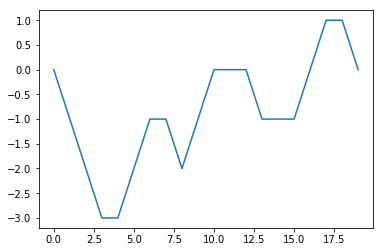

In [ ]:
# посмотрим, как будет выглядеть блуждание на 20 шагах
walk = unirwalk(20)
plt.plot(walk)

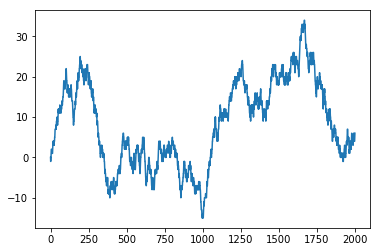

In [ ]:
# посмотрим, как будет выглядеть блуждание на 2000 шагах
walk2 = unirwalk(2000)
plt.plot(walk2)

Чем больше временной интервал, тем дальше будет удалаяться Афанасий от точки старта

In [ ]:
# среднее значение и стандартное отклонение случайного блуждания:
print('mean и std для num=20:',np.mean(walk), np.std(walk))
print('mean и std для num=2000:',np.mean(walk2), np.std(walk2))

mean и std для num=20: -0.85 1.10792599031
mean и std для num=2000: 8.4135 10.568941184


Давайте создадим нормальное случайное блуждание

In [ ]:
# num - число шагов
# a - множитель. В каждый момент времени следующее значение равно a*текущее + белый шум
# mu, sigma - параметры шума
def normrwalk(num,a, mu, sigma):
    eps = np.random.normal(mu, sigma, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = a*walk[i-1] + eps[i]
    return walk
    

Давайте посмотрим, как ведет себя нормальное случайное блуждание для значения a=0.1, 0.5, 0.9, и 1

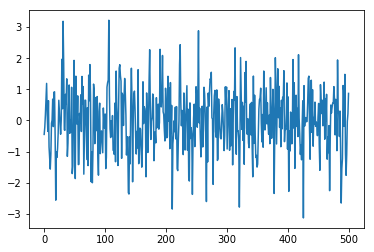

In [ ]:
a = 0.1
n_walk_01 = normrwalk(500, a, 0, 1)
plt.plot(n_walk_01)

In [ ]:
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера

test = sm.tsa.adfuller(n_walk_01)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  0.0
 ряд стационарен


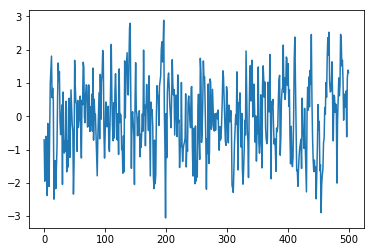

In [ ]:
a = 0.5
n_walk_05 = normrwalk(500, a, 0, 1)
plt.plot(n_walk_05)

In [ ]:
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(n_walk_05)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  1.60562528078e-23
 ряд стационарен


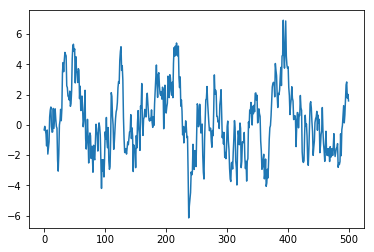

In [ ]:
a = 0.9
n_walk_09 = normrwalk(500, a, 0, 1)
plt.plot(n_walk_09)

In [ ]:
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(n_walk_09)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  1.35387880352e-06
 ряд стационарен


При а=1 ряд резко меняет поведение и перестает быть стационарным! Это так называемый случай единичного корня, на идее которого и работает тест Дикки-Фуллера

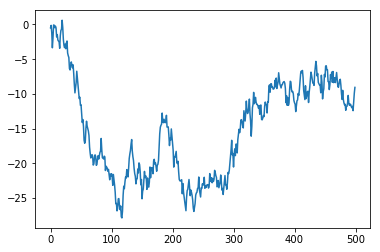

In [ ]:
a = 1
n_walk_1 = normrwalk(500, a, 0, 1)
plt.plot(n_walk_1)

In [ ]:
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(n_walk_1)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  0.210089813538
ряд не стационарен


## Задания

Задание 9.1

Сгенерируйте 100 значений временного ряда по правилу Xt = 0.2Xt-1 + 0.1Xt-2 + et.

В качестве шумовой компоненты et возьмите нормальный белый шум с нулевым средним и единичной дисперсией.

Постройте его график.

Проверьте его на стационарность по критерию Дикки-Фуллера

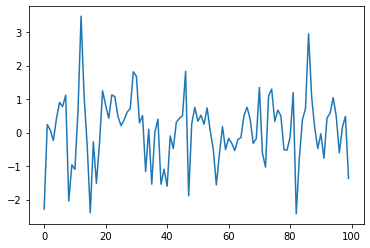

In [4]:
# num - число шагов
# a - множитель. В каждый момент времени следующее значение равно a*текущее + белый шум
# mu, sigma - параметры шума
def normrwalk(num, mu, sigma, t1, t2):
    eps = np.random.normal(mu, sigma, size=num)
    walk = np.zeros(num)
    walk[0], walk[1] = eps[0], eps[1]
    for i in range (1,num):
        walk[i] = t1*walk[i-1] + t2*walk[i-2] + eps[i]
    return walk

time_series_100 = normrwalk(num=100, mu=0, sigma=1, t1=0.2, t2=0.1)
plt.plot(time_series_100)

In [5]:
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(time_series_100)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  8.72077947270487e-12
 ряд стационарен


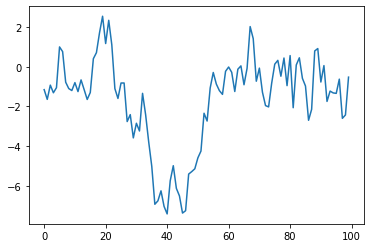

In [6]:
time_series_100 = normrwalk(num=100, mu=0, sigma=1, t1=0.9, t2=0.07)
plt.plot(time_series_100)

In [7]:
test = sm.tsa.adfuller(time_series_100)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  0.13463206492962615
ряд не стационарен


In [ ]:
В этом ноутбуке можно посмотреть, как были получены графики из презентации в видео

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm # отсюда будем брать тест Дикки-Фуллера
import matplotlib.pyplot as plt
import math as m
from scipy import stats

%matplotlib inline


Конфетный датасет содержит ежемесячные данные по производству конфет в США с 1979 по 2017 год

In [8]:
# прочитаем данные из датасета и подготовим их для дальнейшего анализа
df = pd.read_csv('candy_production.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'], format = '%Y-%m-%d')
df = df.set_index(pd.DatetimeIndex(df['observation_date']))
df.drop(['observation_date'], axis =1, inplace = True)
df.head(5)

,IPG3113N
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


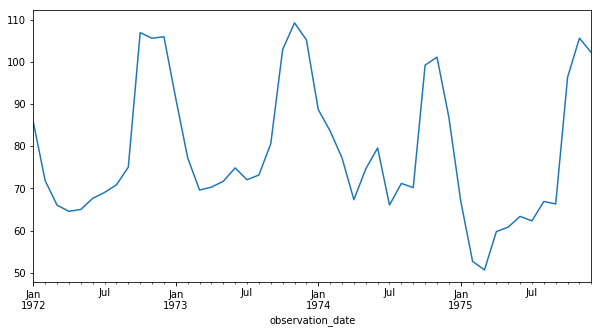

In [10]:
# создадим массив данных по производству конфет, назовем его can и построим график за первые 48 месяцев
can=df.IPG3113N
can[0:48].plot(figsize=(10,5))

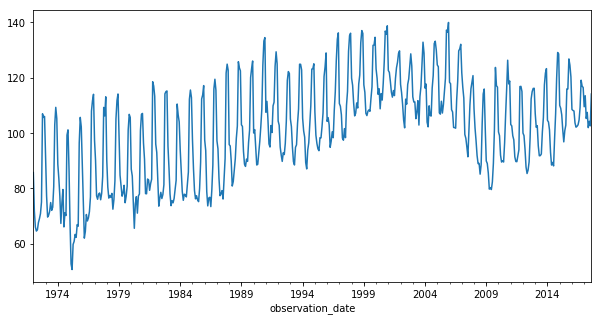

In [11]:
# построим график по всем наблюдениям
can.plot(figsize=(10,5))

По графикам хорошо видно наличие сезонности и тренда.
Протестируем ряд на стационарность по критерию Дикки-Фуллера. В качестве порогового значения p-value возьмем 0.05
adfuller возвращает довольно много разных параметров, p-value находится в массиве test под номером 1

In [12]:
test = sm.tsa.adfuller(can)
p_value = test[1]
print ('p-value: ', p_value)
if p_value> 0.05: 
    print (' ряд не стационарен')
else:
    print ('ряд стационарен')

p-value:  0.3381775973
 ряд не стационарен


Следующий датасет - производство солнечной энергии. В нем наc интересует столбец cum_power

In [19]:
df2 = pd.read_csv('solarpower_cumuldaybyday2.csv')
df2['date'] = pd.to_datetime(df2['date'], format = '%d/%m/%Y')
df2 = df2.set_index(pd.DatetimeIndex(df2['date']))
df2.drop(['date'], axis =1, inplace = True)
df2.drop(['Unnamed: 2'], axis =1, inplace = True)
df2.head(5)

,cum_power
date,
2011-10-26,0.1
2011-10-27,10.2
2011-10-28,20.2
2011-10-29,29.6
2011-10-30,34.2


Нарисуем график. По нему хорошо видно, что это именно накопленная энергия: cumupative power, так как она монотонно растет

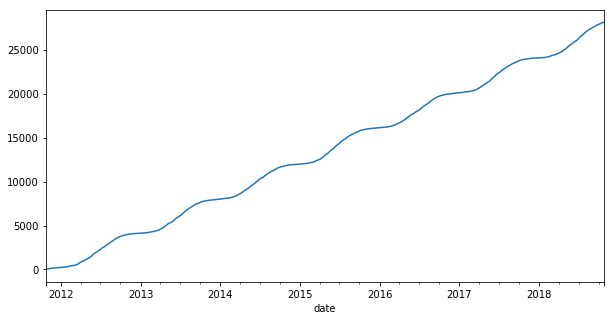

In [20]:
sp=df2.cum_power
sp.plot(figsize=(10,5))

Давайте посмотрим на ежедневное производство электроэнергии. Для этого найдем приращения нашего ряда: из каждого значения ряда вычтем предыдущее.

В питоне для этого есть специальная команда sp.diff(periods=1).dropna(). Здесь написано, что нужно взять разность с периодом 1 (из каждого вычесть предыдущее) и выкинуть пустые значения

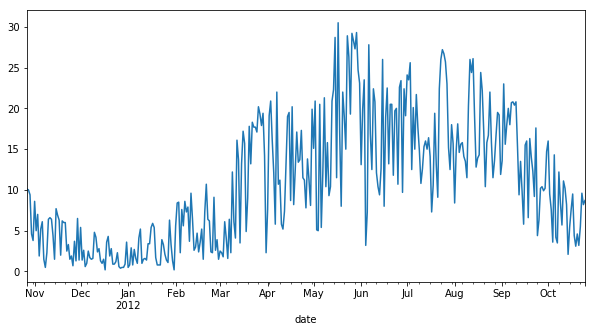

In [21]:
dayp = sp.diff(periods=1).dropna()
# нарисуем график за первый год наблюдений
dayp[0:365].plot(figsize=(10,5))

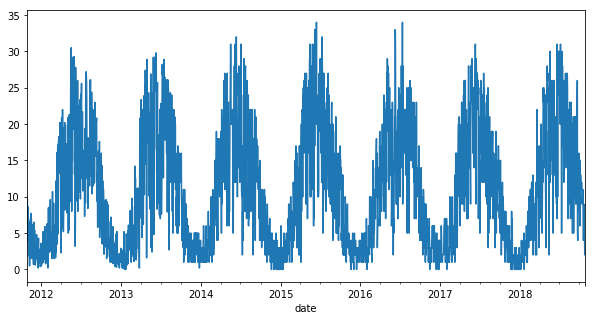

In [22]:
# нарисуем график за все время наблюдения. Этот ряд также не стационарен.
dayp.plot(figsize=(10,5))

Рисуем картинки для акций Uniqlo

In [46]:
df3 = pd.read_csv('uniqlo.csv')
df3['Date'] = pd.to_datetime(df3['Date'], format = '%Y-%m-%d')
df3 = df3.set_index(pd.DatetimeIndex(df3['Date']))
# столбец Date нам больше не нужен, удалим его
df3.drop(['Date'], axis =1, inplace = True)
df3.shape

(1226, 6)

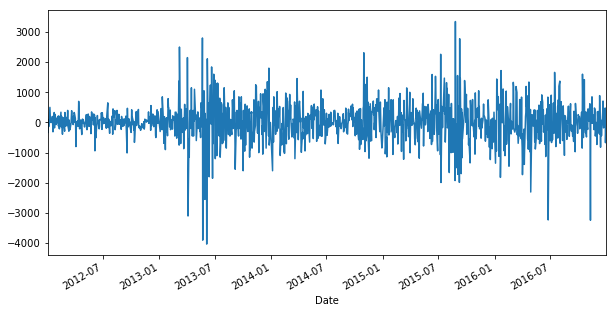

In [47]:
# Составим временной ряд разностей цены закрытия биржи и цены открытия биржи
diff =  df3.Close - df3.Open
diff.plot(figsize=(10,5))

In [48]:
# Наш ряд выглядит неплохо - не заметно ни трендов, ни сезонности. Проверим стационарность тестом Дикки-Фуллера
test = sm.tsa.adfuller(diff)
p_value = test[1]
print ('p-value: ', p_value)
if p_value> 0.05: 
    print (' ряд не стационарен')
else:
    print ('ряд стационарен')

p-value:  0.0
ряд стационарен


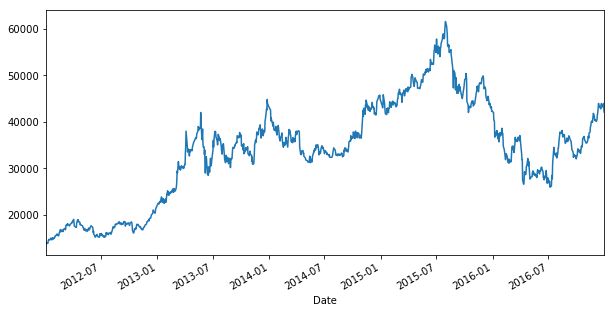

In [49]:
# Построим график для цены открытия.
openpr=df3.Open
openpr.plot(figsize=(10,5))

In [50]:
# График напоминает случайное блуждание. Невооруженным взглядом видно, что он ряд не стационарен, но все же проведем проверку
test = sm.tsa.adfuller(openpr)
p_value = test[1]
print ('p-value: ', p_value)
if p_value> 0.05: 
    print (' ряд не стационарен')
else:
    print ('ряд стационарен')

p-value:  0.814187192956
 ряд не стационарен


Последний пример в этом блоке - котировки доллара на бирже криптовалют.
Среди столбцов нам интересны baseAsset - btc, quoteAsset - true USD
bidPrice - цена предложения для 1 true dollar

In [51]:
df4 = pd.read_csv('BTCTUSD.csv')
df4.columns

Index(['active', 'activeBuy', 'activeSell', 'baseAsset', 'baseAssetName',
       'baseAssetUnit', 'close', 'decimalPlaces', 'high', 'lastAggTradeId',
       'low', 'market', 'marketName', 'matchingUnitType', 'minQty', 'minTrade',
       'open', 'parentMarket', 'parentMarketName', 'prevClose', 'productType',
       'quoteAsset', 'quoteAssetName', 'quoteAssetUnit', 'status', 'symbol',
       'tickSize', 'tradedMoney', 'volume', 'withdrawFee', 'bidPrice',
       'bidQty', 'askPrice', 'askQty', 'timestamp'],
      dtype='object')

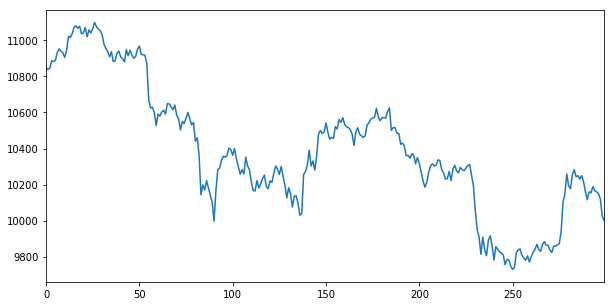

In [52]:
df4.bidPrice[0:300].plot(figsize=(10,5))

In [53]:
# График напоминает случайное блуждание. Невооруженным взглядом видно, что ряд не стационарен, но все же проведем проверку
test = sm.tsa.adfuller(df4.bidPrice)
p_value = test[1]
print ('p-value: ', p_value)
if p_value> 0.05: 
    print (' ряд не стационарен')
else:
    print ('ряд стационарен')

p-value:  0.752188809153
 ряд не стационарен


- как строить и интерпретировать ACF и  PACF

- В примерах 1-6 мы посмотрим, как выглядят коррелограммы для искусственно сгенерированных AR, MA и ARMA рядов

- В примере 7 поглядим, выглядят коррелограммы реальных данных

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Создадим функции, которые будут генерировать процессы AR(1), MA(1), AR(2), AR(3), ARMA(2,2) со стандартным нормальным белым шумом

In [2]:
# ar геренирует ряд AR(1) без константы с коэффициентом phi

def ar(num,phi):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = phi*walk[i-1] + eps[i]
    return walk

# ma геренирует ряд MA(1) без константы с коэффициентом theta

def ma(num,theta):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = theta*eps[i-1] + eps[i]
    return walk

# ar2 геренирует ряд AR(2) без константы с коэффициентами phi1, phi2

def ar2(num,phi1,phi2):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = phi1*walk[i-1] + phi2*walk[i-2] + eps[i]
    return walk

# ar3 геренирует ряд AR(3) без константы с коэффициентами phi1, phi2, phi3

def ar3(num,phi1,phi2,phi3 ):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = phi1*walk[i-1] + phi2*walk[i-2] + phi3*walk[3] + eps[i]
    return walk

# arma22 геренирует ряд ARMA(22) без константы с коэффициентами phi1, phi2, theta1, theta2

def arma22(num,phi1,phi2,theta1,theta2 ):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = phi1*walk[i-1] + phi2*walk[i-2] + eps[i] + theta1*eps[i-1] + theta2*eps[i-2]
    return walk

Сгенерируем процесс MA(1) и нарисуем его график

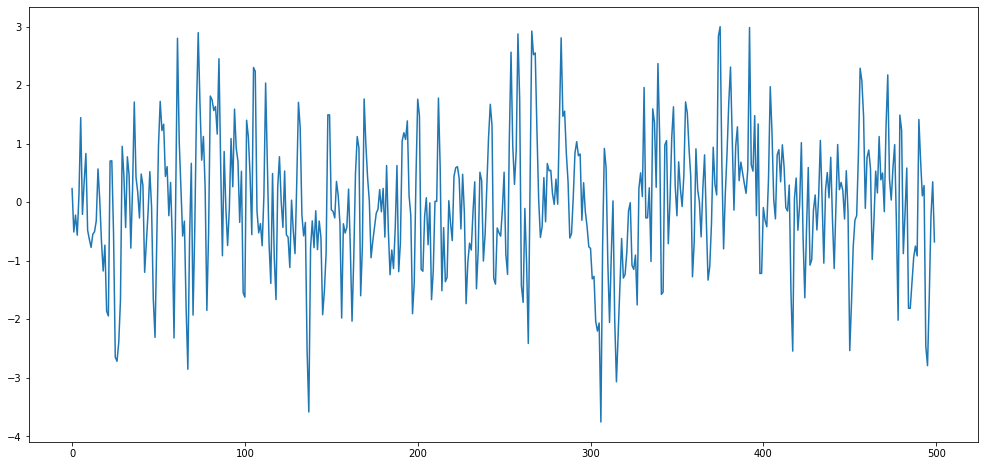

In [3]:
ma1 = ma(500, 0.7)
plt.figure(figsize(17,8))
plt.plot(ma1)

Пример 1
Построим acf и pacf для сгенерированного процесса. 

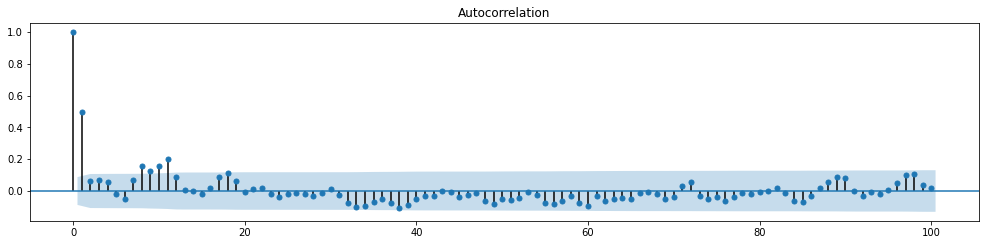

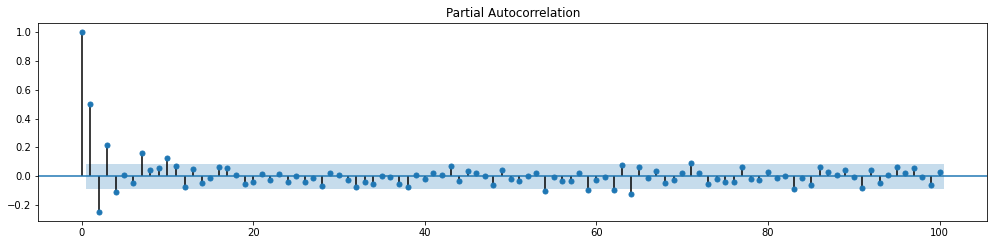

In [4]:
plt.figure(figsize(17,8))
ax = plt.subplot(211)
# tsa.plot_acf рисует коррелограмму acf. lags=100 задает число лагов, для которых строится acf
sm.graphics.tsa.plot_acf(ma1.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ma1.squeeze(), lags=100, ax=ax)
plt.show()

Основная информация о MA модели содержится в ее acf коррелограмме. На ней явно видно, что первый лаг существенно отличается от нуля, а последующие лежат в рамках синей области, то есть их можно с большой уверенностью считать нулями

Пример 2
Сгенерируем процесс белого шума и нарисуем его график

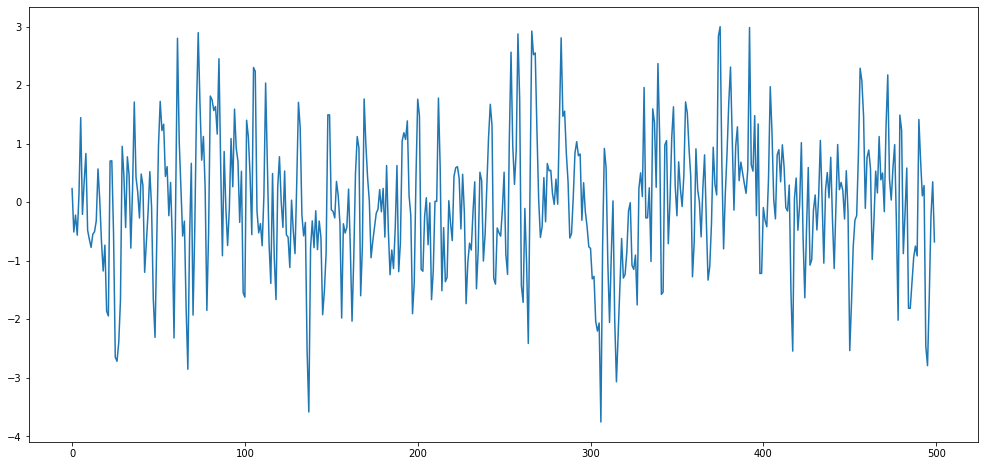

In [5]:
eps = np.random.normal(0, 1, size=500)
plt.plot(ma1)

Визуально процесс белого шума не сильно отличается от MA(1)

Однако на коррелограммах разница заметна:

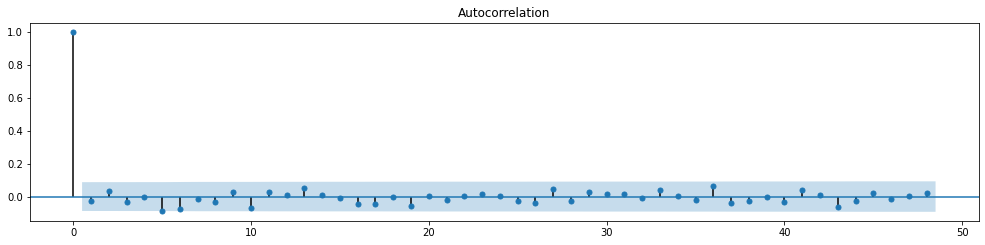

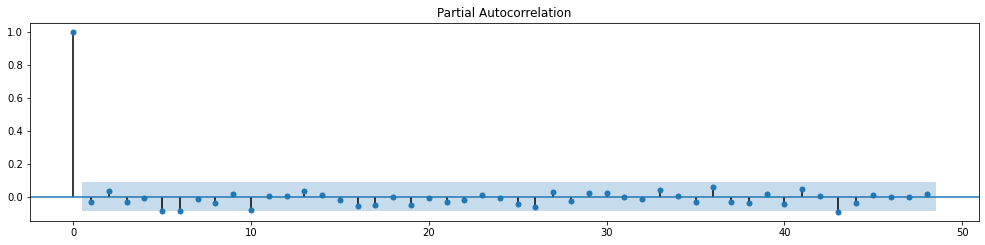

In [6]:
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(eps.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(eps.squeeze(), lags=48, ax=ax)
plt.show()

Как видите, у белого шума нет сущесвенно отличных от нуля лагов на обеих коррелограммах. Это вполне понятно, тк процесс белого шума является совершенно хаотичным

Пример 3

Сгенерируем процесс авторегрессии AR(1) и нарисуем его график

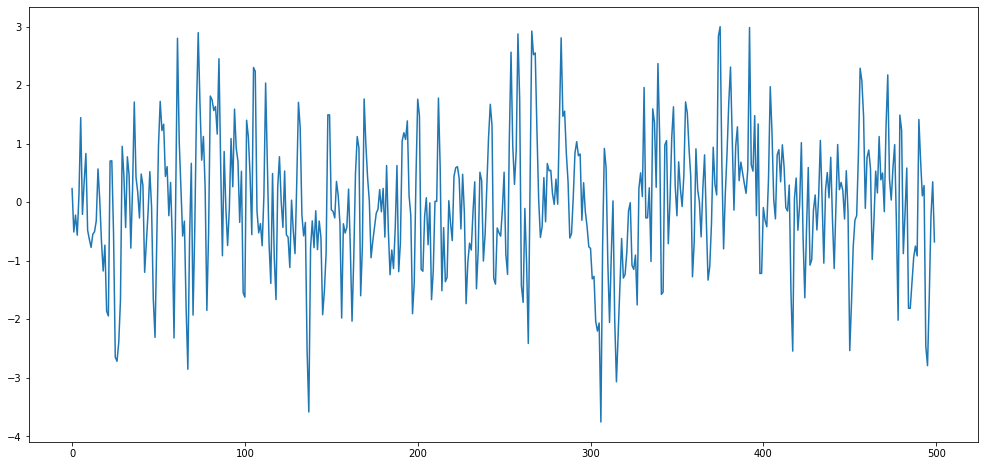

In [7]:
ar1= ar(500, 0.8)
plt.figure(figsize(17,8))
plt.plot(ma1)

Снова сложно отличить это случайное блуждание от белого шума. Давайте посмотрим на коррелограммы

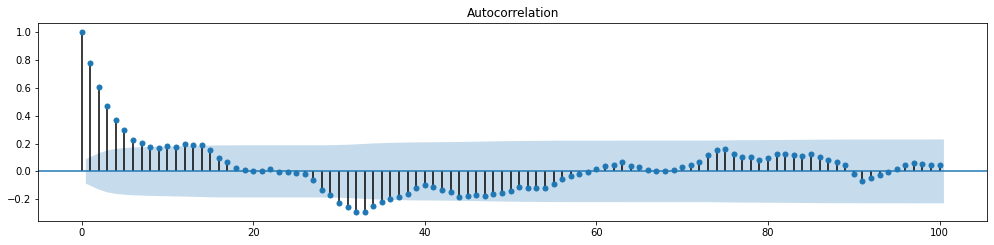

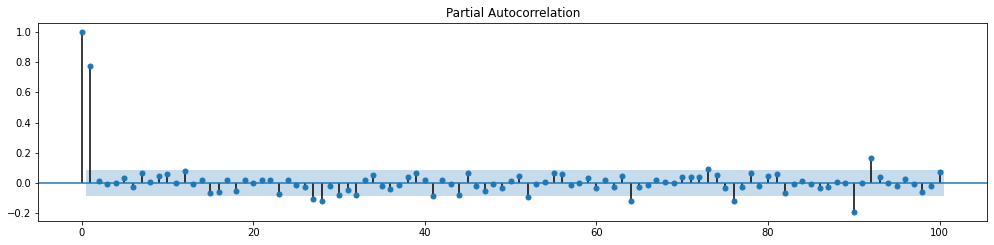

p-value теста Дики-Фуллера: 1.2855349258562378e-11


In [8]:
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ar1.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ar1.squeeze(), lags=100, ax=ax)
plt.show()
print("p-value теста Дики-Фуллера:",  sm.tsa.stattools.adfuller(ar1)[1])

Коррелограмма ACF типична для процессов типа AR(1). Видим на ней в начале убывание лагов по геометрической прогресии, как и предсказывает нам теория

На частичной коррелограмме PACF мы видим один лаг (первый), сильно отличающийся от нуля.

Пример 4

Сгенерируем процесс авторегрессии AR(2) и AR(3) и нарисуем их коррелограммы

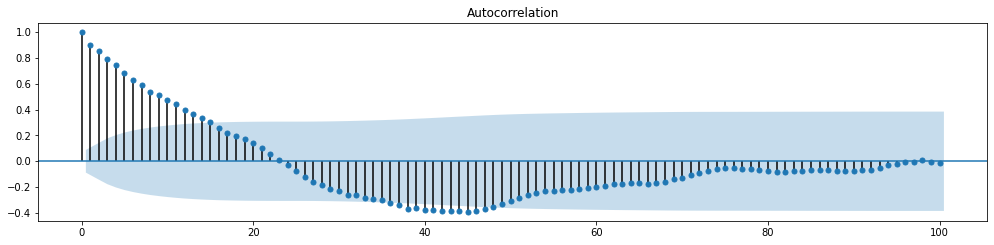

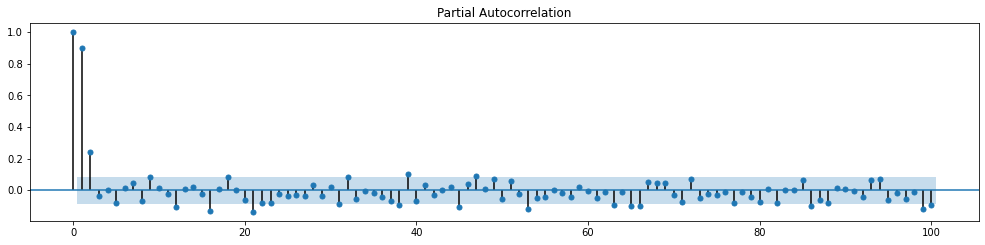

p-value теста Дики-Фуллера: 0.0020388703543022003


In [9]:
ar2_ = ar2(500, 0.7,0.2)
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ar2_.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ar2_.squeeze(), lags=100, ax=ax)
plt.show()
print("p-value теста Дики-Фуллера:",  sm.tsa.stattools.adfuller(ar2_)[1])

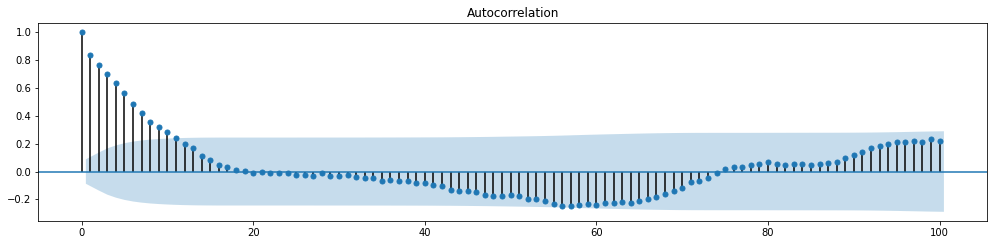

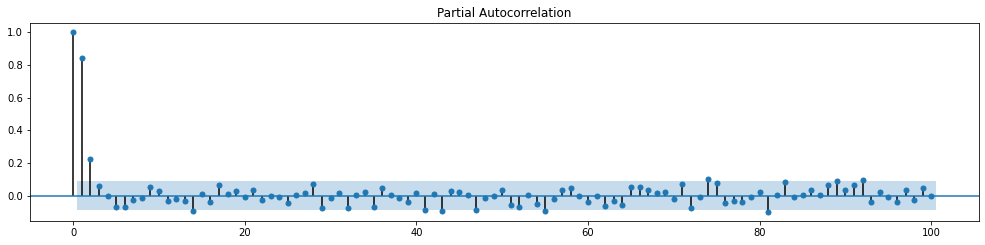

p-value теста Дики-Фуллера: 1.347991958407007e-05


In [10]:
ar3_ = ar3(500,0.7,0.2,-0.1)
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ar3_.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ar3_.squeeze(), lags=100, ax=ax)
plt.show()
print("p-value теста Дики-Фуллера:",  sm.tsa.stattools.adfuller(ar3_ )[1])

Снова типичная картинка ACF для AR(p) процессов - экспоненциальное (т.е. по геометрической прогрессии) убывание лагов

Пример 5

Давайте посмотрим, как выглядят коррелограммы нестационарных рядов.

Сгенерируем случайное блуждание с коэффициентом 1

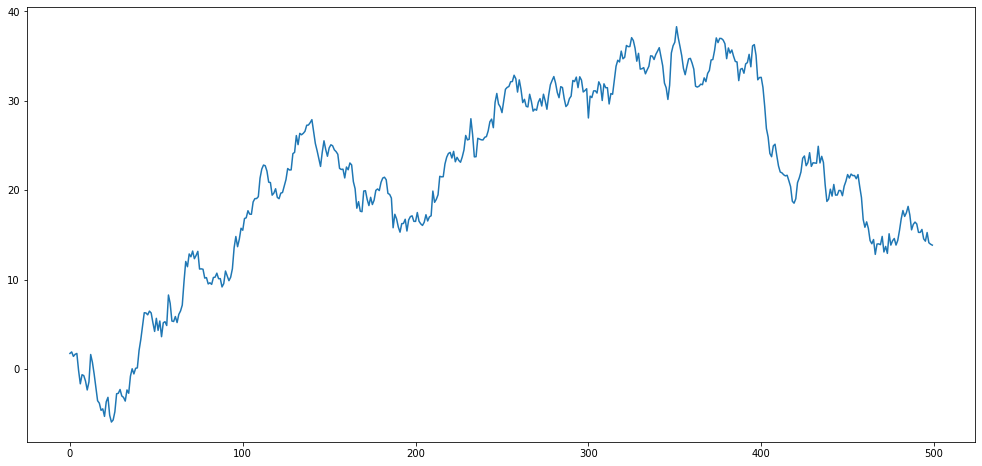

In [11]:
ar_n = ar(500,1)
plt.plot(ar_n)

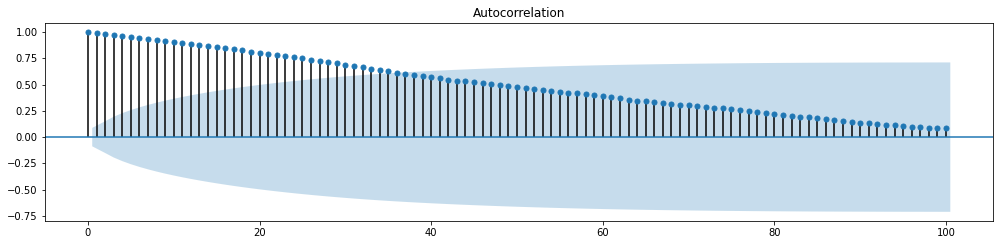

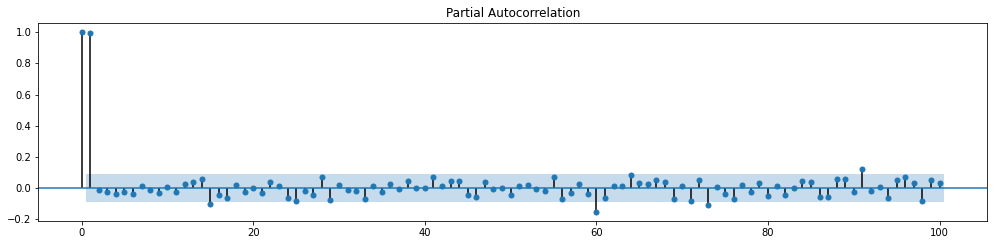

p-value теста Дики-Фуллера: 0.406100252606385


In [12]:
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ar_n.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ar_n.squeeze(), lags=100, ax=ax)
plt.show()
print("p-value теста Дики-Фуллера:",  sm.tsa.stattools.adfuller(ar_n )[1])

Ряд имеет ярко выраженный (хоть и случайный) тренд. Это сказывается на его ACF коррелограмме - автокорреляции завышены

На частичной коррелограмме (PACF) видим один отличный от нуля лаг - первый

Пример 6

Сгенерируем ряд  ARMA(2,2) и посмотрим на его коррелограммы. Для комбинированных моделей ARMA(p,q) коррелограммы могут некорректно отражать количество параметров

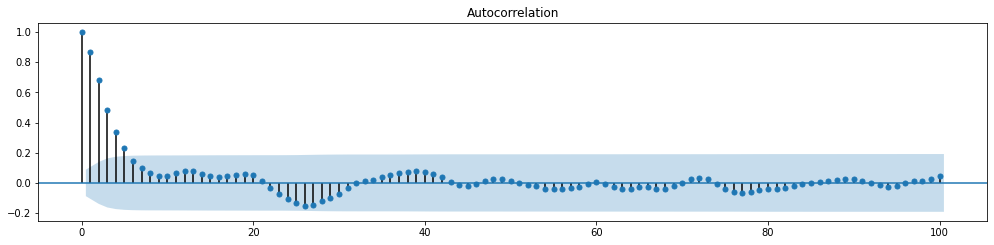

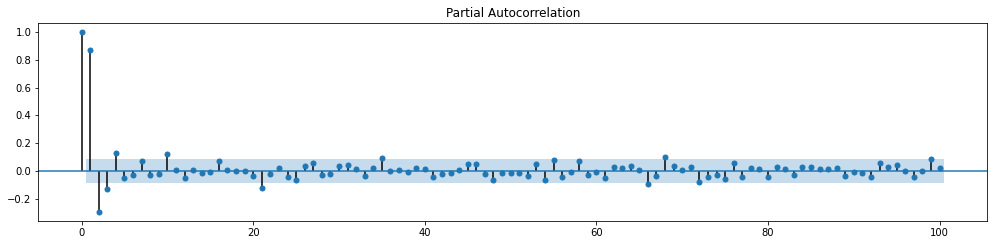

In [13]:
arma = arma22(500,0.5,0.2,0.6,0.3)
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(arma.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(arma.squeeze(), lags=100, ax=ax)
plt.show()

Пример 7

Нарисуем коррелограммы для конфетного временного ряда

(548, 2)


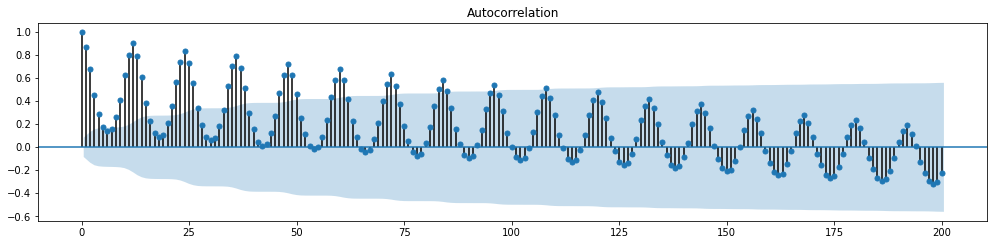

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


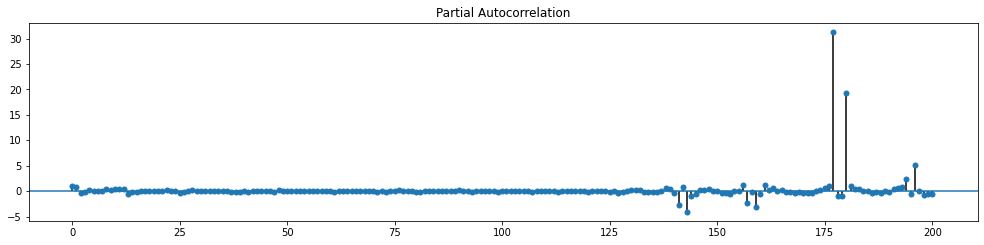

Критерий Дики-Фуллера: p=0.338178


In [28]:
df = pd.read_csv('candy_production.csv')
print(df.shape)
df['observation_date'] = pd.to_datetime(df['observation_date'], format = '%Y-%m-%d')
df = df.set_index(pd.DatetimeIndex(df['observation_date']))
df.drop(['observation_date'], axis =1, inplace = True)
candy=df.IPG3113N
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(candy.squeeze(), lags=200, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(candy.squeeze(), lags=200, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(candy)[1])

Обратите внимание на ACF - именно так выглядит комбинация тренда и сезонности. Тренд сдвигает значения корреляций вверх, а сезонность добавляет колебания с постоянным (это важно!) периодом

# Задания

### 13.1

Постройте полную и частичную коррелограмму данных о пасажиропотоке.

(144, 2)


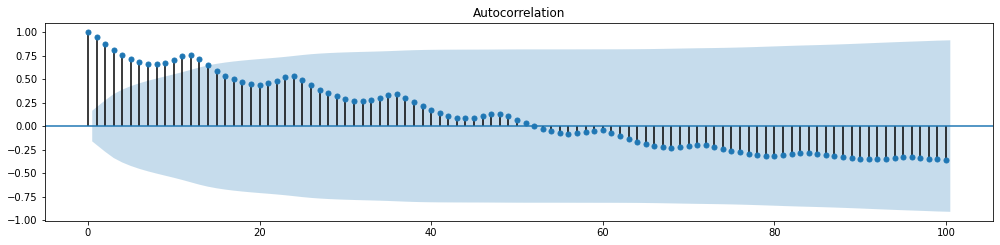

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


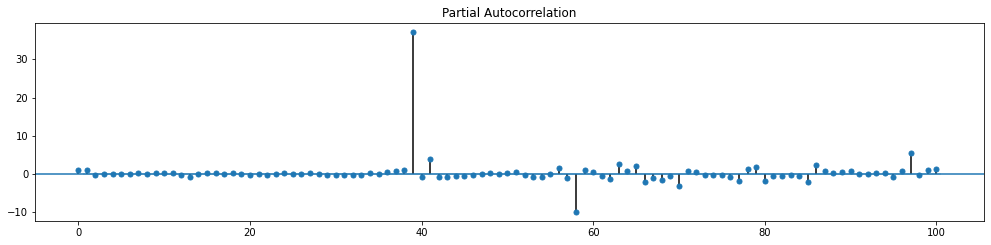

Критерий Дики-Фуллера: p=0.991880


In [29]:
df = pd.read_csv('AirPassengers.csv')
print(df.shape)
df['Month'] = pd.to_datetime(df['Month'], format = '%Y-%m')
df = df.set_index(pd.DatetimeIndex(df['Month']))
df.drop(['Month'], axis =1, inplace = True)
passenger=df['#Passengers']
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(passenger.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(passenger.squeeze(), lags=100, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(passenger)[1])

### 13.2

Постройте полную и частичную коррелограмму первых разностей данных о пасажиропотоке.

In [31]:
df['diff_1'] = df['#Passengers'].diff()
df.head()

,#Passengers,diff_1
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


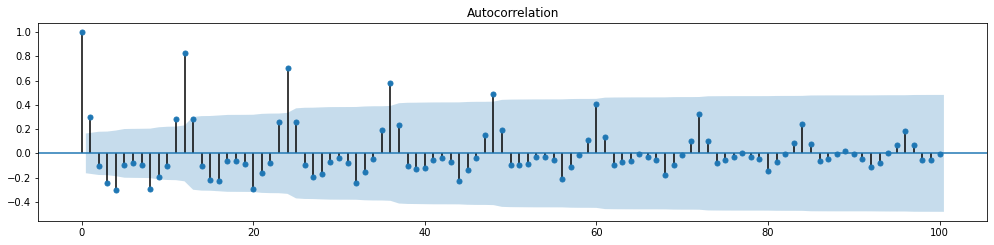

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


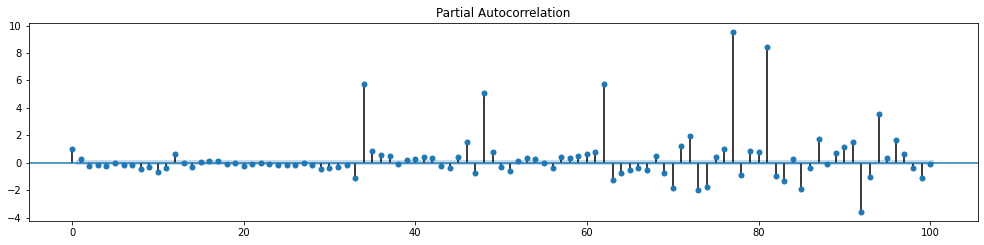

Критерий Дики-Фуллера: p=0.054213


In [34]:
diff_1=df['diff_1'][1:]
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(diff_1.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(diff_1.squeeze(), lags=100, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(diff_1)[1])

## 13.3

Постройте полную и частичную коррелограмму вторых разностей данных о пасажиропотоке.

In [35]:
df['diff_2'] = df['diff_1'].diff()
df.head()

,#Passengers,diff_1,diff_2
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


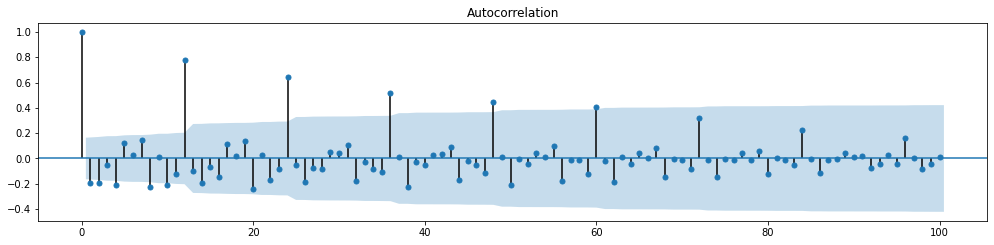

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


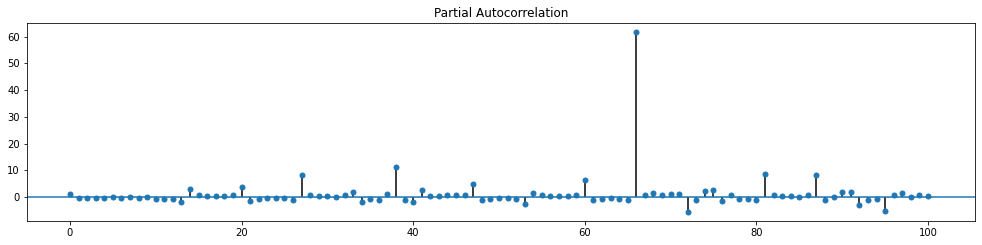

Критерий Дики-Фуллера: p=0.000000


In [37]:
diff_2=df['diff_2'][2:]
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(diff_2.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(diff_2.squeeze(), lags=100, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(diff_2)[1])

# Предсказание погоды
## Coding Stream 

Что мы хотим сделать?  
У нас есть данные по погоде за несколько лет со многих метеостанций.  
Мы попытаемся предсказать погоду на следующий день по предыдущим N дням с помощью линейной регрессии.

Для начала качаем данные с ftp.

In [ ]:
import shutil
import urllib
from contextlib import closing

with closing(urllib.request.urlopen('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2018.csv.gz')) as r:
    with open('./2018.csv.gz', 'wb') as f:
        shutil.copyfileobj(r, f)

Файлы довольно большие, поэтому мы не хотим их считывать с помощью pandas. Вместо этого мы используем средства самого Python.

Формат следующий. Файл csv, каждая строка такая:   
`<id_станции>, <дата>, <метрика>, <значение>, <другие_параметры>`  
Нас интересуют первые 4 столбца

Мы прочитаем все интересующие нас данные в память и выберем те метеостанции, которые вернули показания по средней дневной температуре и направлению ветра в каждый из дней года.

Dask – альтернатива pandas, позволяет делать многопоточные вычисления.

Еще есть Spark/PySpark, hdfs (библиотека – hdf5)

In [ ]:
import pandas as pd

In [ ]:
%time data_2016 = pd.read_csv("./2016.csv", header=None)

<string>:2: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 17.3 s, sys: 5 s, total: 22.3 s
Wall time: 23.1 s


In [ ]:
!head -10 2016.csv

AE000041196,20160101,TMIN,155,,,S,
AE000041196,20160101,TAVG,229,H,,S,
AEM00041194,20160101,PRCP,0,,,S,
AEM00041194,20160101,TAVG,241,H,,S,
AEM00041218,20160101,TMIN,182,,,S,
AEM00041218,20160101,TAVG,241,H,,S,
AEM00041217,20160101,TMAX,310,,,S,
AEM00041217,20160101,TMIN,166,,,S,
AEM00041217,20160101,TAVG,238,H,,S,
AFM00040938,20160101,TAVG,143,H,,S,


## Необходимый код

In [ ]:
import sys
from sklearn import linear_model


def days_in_year(year):
    if year % 4 != 0:
        return 365
    if year % 400 == 0:
        return 366
    if year % 100 == 0:
        return 365
    return 366


def parse_years(years):
    """
    codes = {
        code: {
            'dt': {
                'TAVG': float,
                'SNWD': float
            }
        }
    }
    
    codes = {
        'AEM00041218': {
            '20160101': {
                'TAVG': -5,
                'SNWD': 0
            },
            '20160102' : {
                ...
            }
        },
    }
    
    result = {
        code: [
            (temp1, wind1),
            (temp2, wind2),
            ...
        ]
    }
    """
    result = {}
    for year in years:
        codes = {}
        for line in open('{year}.csv'.format(year=year), 'rt'):
            if line and line[-1] == '\n':
                line = line[:-1]
            data = line.split(',')
            code, dt, metric, value = data[0:4]
            if metric not in ['TAVG', 'SNWD']:
                continue
            if code not in codes:
                codes[code] = {}
            dates = codes[code]
            if dt not in dates:
                dates[dt] = {}
            dates[dt][metric] = float(value) / 10
        for code, dates in codes.items():
            data_temp = [dates[dt]['TAVG'] for dt in sorted(dates.keys()) if 'TAVG' in dates[dt]]
            data_wind = [dates[dt]['SNWD'] for dt in sorted(dates.keys()) if 'SNWD' in dates[dt]]
            if len(data_temp) != days_in_year(year) or len(data_wind) != days_in_year(year):
                continue
            if code not in result:
                result[code] = list(zip(data_temp, data_wind))
            else:
                result[code] += list(zip(data_temp, data_wind))
    return result

In [ ]:
def iterate_data(data, window):
    """
    Сюда приходит result
    
    yield создает итератор, который при каждом вызове (или итерации по нему) возвращает один объект за раз
    Это полезно, когда у нас большие файлы, которые мы не хотим грузить в память
    """
    for _, items in data.items():
        for i in range(0, len(items) - window - 1):
             yield items[i : i + window], items[i + window][0]

def calc_mse(data, window, model):
    result, count = 0.0, 0
    for x, y in iterate_data(data, window):
        result += ((model(x) - y)**2)
        count += 1
    return result / count


def prepare_features(x):
    return [x[i][0] for i in range(len(x))] + [x[i][1] for i in range(len(x))]

In [ ]:
def train_linear_regression(data, window):
    X, Y = [], []
    for x, y in iterate_data(data, window):
        X.append(prepare_features(x))
        Y.append(y)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    return regr


def apply_regression(data, model):
    return model.predict([prepare_features(data)])[0]


def baseline_model(data):
    # data is a list of tuples (temp, wind)
    return data[-1][0]

## Чтение данных

Прочитаем наши данные  
Данные для обучения и валидации не должны пересекаться – иначе это прямой путь к переобучению

In [ ]:
train = parse_years([2016])
test = parse_years([2017])

Зададим окно, с которым мы будем обучать модель. Это будет количество дней (признаков/2), на которые мы будем смотреть

In [ ]:
window = 14

## Baseline-модель

Посчитаем метрики на обучении и валидации для нашей baseline-модели.  
В качестве базовой модели выберем такую - будем всегда возвращать температуру за вчерашний день.  

Почему мы делаем так: наша задача состоит в том, чтобы предсказать температуру на следующий день.  
В качестве такого предсказания мы будем возвращать температуру за вчерашний день, так как обычно изменение температуры за соседние дни бывает не очень сильное.

In [ ]:
calc_mse(train, window, baseline_model)

8.72859275309986

In [ ]:
calc_mse(test, window, baseline_model)

8.853850137207615

## Линейная регрессия

Давайте обучим нашу модель линейной регрессии:

In [ ]:
model = train_linear_regression(train, window)

И посмотрим на результаты:

In [ ]:
calc_mse(train, window, lambda x: apply_regression(x, model))

7.317883214892826

In [ ]:
calc_mse(test, window, lambda x: apply_regression(x, model))

7.746158385484083

Получилось, что линейная регрессия справляется лучше, чем baseline-модель.  
Также, метрики не сильно отличаются между обучением и валидацией. Это значит, что переобучения не произошло.

Что, если мы возьмем другой размер окна?

In [ ]:
window = 30
model = train_linear_regression(train, window)
print("MSE train", calc_mse(train, window, lambda x: apply_regression(x, model)))
print("MSE test", calc_mse(test, window, lambda x: apply_regression(x, model)))

MSE train 7.198350517415528
MSE test 7.697311945722793


## Регуляризация

Метрика на валидации заметно выше, чем на обучении. Похоже, мы встретились с переобучением.  
Попробуем применить регуляризацию:

In [ ]:
from sklearn.linear_model import Ridge

def train_ridge_regression(data, window, alpha=1.0):
    X, Y = [], []
    for x, y in iterate_data(data, window):
        X.append(prepare_features(x))
        Y.append(y)
    regr = Ridge(alpha=alpha)
    regr.fit(X, Y)
    return regr

In [ ]:
window = 30
model = train_ridge_regression(train, window, alpha=10)
print("MSE train", calc_mse(train, window, lambda x: apply_regression(x, model)))
print("MSE test", calc_mse(test, window, lambda x: apply_regression(x, model)))

MSE train 7.198350517690733
MSE test 7.697312941918887


In [ ]:
window = 7
model = train_ridge_regression(train, window, alpha=100)
print("MSE train", calc_mse(train, window, lambda x: apply_regression(x, model)))
print("MSE test", calc_mse(test, window, lambda x: apply_regression(x, model)))

MSE train 7.534483237026629
MSE test 7.908413797271512


## Random Forest

Давайте попробуем случайный лес (осторожно, обучается намного дольше регрессии):

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest_regression(data, window, n_estimators=10, max_depth=None):
    X, Y = [], []
    for x, y in iterate_data(data, window):
        X.append(prepare_features(x))
        Y.append(y)
    regr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    regr.fit(X, Y)
    return regr

In [ ]:
window = 30
model = train_random_forest_regression(train, window)
print("MSE train", calc_mse(train, window, lambda x: apply_regression(x, model)))
print("MSE test", calc_mse(test, window, lambda x: apply_regression(x, model)))

MSE train 0.7499780430456969
MSE test 9.17987124192312


Видим, что модель очень сильно переобучилась. Попробуем ограничить глубину деревьев:

In [ ]:
window = 30
model = train_random_forest_regression(train, window, max_depth=2)
print("MSE train", calc_mse(train, window, lambda x: apply_regression(x, model)))
print("MSE test", calc_mse(test, window, lambda x: apply_regression(x, model)))

MSE train 17.667707825236793
MSE test 17.162301206039377


Переобучения больше нет, но результаты даже намного хуже, чем у baseline-модели. По-хорошему тут нужно запускать grid search на разные параметры, но это очень долго.

Над чем еще можно было бы поработать?

 * Использовать те метеостанции, которые не вернули данные за весь год - улучшит это обучение или ухудшит?
 * Учесть месяц/время года в качестве признаков
 * Учесть геопозицию метеостанции (это есть в соседних файлах на ftp, их можно скачать)
 * Изменить предобработку данных?
 * Что еще?